# a priori vs a posteriori: troubles with global maps & Wilk's FDR
### by Elizabeth Barnes

Much of geophysical research involves creating maps of a result, and often, scientists will assess the significance of each value on the map individually. As discussed above, one should expect a certain fraction of points to be "significant", even if the null hypothesis is true. Furthermore, many geophysical variables are spatially correlated, implying that significant points will likely appear clustered. Let's look at an example of this.

In the example that follows, we create a figure of daily January 500 hPa geopotential heights at each latitude/longitude grid point correlated with a time series $Z$. Correlations different from zero at 95\% confidence are stippled, and appear to show signals across the globe, with the largest signal in the tropical Pacific. The trick here is that $Z$ is a random Gaussian time series, with absolutely no physical meaning. Thus, in many applications, assessing the significance at each grid point is not enough - rather - one should assess the collective significance, or *field significance* over the entire map as discussed in the final section of this notebook. 


In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import scipy.signal as signal
import h5py
import scipy.io as io

# import matplotlib.patches as mpatches
import cartopy as ct
# import cmocean as cmocean
# import cmocean.plots
import random

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100



In [2]:
random.seed(30)
np.random.seed(seed=16)

Here we load the data, currently stored as a Matlab .mat file.

In [3]:
DATA = io.loadmat('data/z500_daily.mat')    
Xall = np.array(DATA['X'])
LAT = np.array(DATA['LAT'])[0,:]
LONG = np.array(DATA['LONG'])[0,:]
TIME = np.array(DATA['TIME'])
print('data is loaded')

data is loaded


Next we grab every other latitude/longitude value to reduce computation time, and we rearrange longitudes so that there is no gap at 360E. To further reduce the amount of data, we only grab the month of December (month = 12).

In [4]:
# grab every other
Xall = Xall[:,::2,::2]
LAT = LAT[::2]
LONG = LONG[::2]

# get data so there is no gap at 360E
Xall = np.insert(Xall, 0, values=Xall[:,:,0], axis=2)
LONG = np.insert(LONG,0,values = 0.)

Xall = np.insert(Xall, -1, values=Xall[:,:,-1], axis=2)
LONG = np.insert(LONG,-1,values = LONG[-1])
LONG[-1] = 360

del DATA

# grab the month of December
X = Xall
month = 12
itime = np.logical_and(TIME[:,2]==12, TIME[:,3]==1) #only grab December 1 days
X = X[itime,:,:]

We are now going to make our random time series $Z$. We can use the numpy module called "random" to do this, and we make sure $Z$ has the same number of time steps as $X$. *Remember though - Z is totally random and has no knowledge of the atmosphere!*

latitude = 60.0; longitude = 0.0


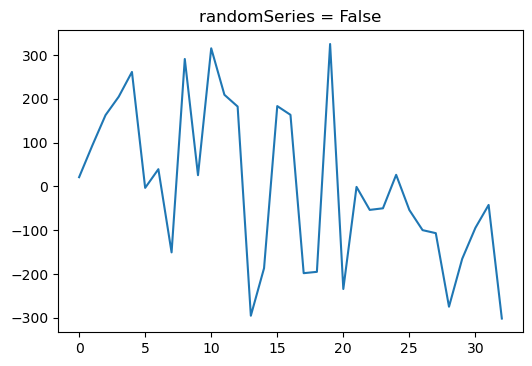

In [11]:
# uncomment below when discussing Wilks
randomSeries = False # whether or not to use random time series or real time series

if(randomSeries):
    Z = np.random.normal(size=(np.shape(X)[0],))  
else:
    print('latitude = ' + str(LAT[5]) + '; longitude = ' + str(LONG[0]))
    Z = X[:,5,0]
Z = Z - np.mean(Z)

plt.figure()
plt.plot(Z)
plt.title('randomSeries = ' + str(randomSeries))
plt.show()

Ok - here comes the fun part. Let's correlate the geopotential height field at every point on our globe with the random time series $Z$. We will also save the p-values for significance testing later.

In [12]:
P = np.empty((X.shape[1],X.shape[2]))
C = np.empty((X.shape[1],X.shape[2]))

for ilat,vallat in enumerate(LAT):
    for ilon,vallon in enumerate(LONG):
        corr_val,p = stats.pearsonr(Z,X[:,ilat,ilon])
        P[ilat,ilon] = p
        C[ilat,ilon] = corr_val

So, what do we get? We can make a map of the correlations C, and then stipple the locations with p-values less than 0.05 (that is, 95% confidence). Here's the final result.

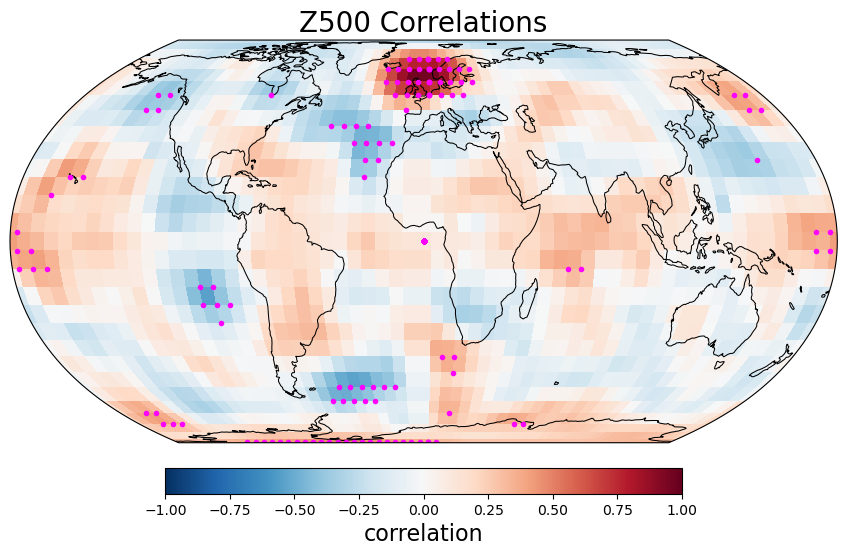

In [13]:
data_crs = ct.crs.PlateCarree()

plt.figure(figsize=(16/1.2,8/1.2))
ax = plt.subplot(projection=ct.crs.EqualEarth())
ax.set_global()
ax.coastlines(linewidth = .75)
image = ax.pcolor(LONG, LAT, C, transform=data_crs, cmap='RdBu_r', shading='auto')
cb = plt.colorbar(image, shrink=.5, orientation="horizontal", pad=.05)
cb.set_label('correlation', fontsize=16)
maxval = np.max(C[:])
image.set_clim(-maxval,maxval)

for ilat,vallat in enumerate(LAT):
    for ilon,vallon in enumerate(LONG):
        if(P[ilat,ilon]<0.05):
            ax.plot(vallon+np.abs(np.diff(LONG)[1])/2,vallat-np.abs(np.diff(LAT)[1])/2,'o',markersize = 3, color = 'fuchsia', transform=data_crs)
            
plt.title('Z500 Correlations', fontsize=20)
plt.show()


Notice how there is stippling even though we *know* there is no true relationship between $X$ and $Z$. Not only that, but the stippling appears in clusters - making it appear like it might actually mean something! The clustering occurs because the physical field, here, the geopotential height field, has spatial correlation - and thus, things tend to go up and down similarly between neighboring locations.

This should **terrify** you! How do you know when you are looking at a random relationship versus a real one? Well - you have to be a scientist - not a robot. You have to think about the physical mechanisms that might explain your results. In addition, there are ways of quantifying "global significance", as discussed below.

### Wilk's False Discovery Rate

[Wilks (2016; BAMS)](http://journals.ametsoc.org/doi/abs/10.1175/BAMS-D-15-00267.1) outlined a straight-forward way to assess field significance by controlling the *false discovery rate* (FDR), or, the expected rate of rejected local null hypotheses where the actual null hypothesis is true. The general idea is that one sorts the list of p-values (across grid points), and then finds which p-value intersects the line defined by $y = \frac{i}{N}\alpha_{FDR}$ where $i$ is the position of the p-value in the sorted list, $N$ is the total number of grid points, and $\alpha_{FDR}$ is a parameter that is chosen by the user. The p-value at the intersection is then the global p-value that each grid point must be smaller than to satisfy a particular false detection rate.  

An illustration of the calculation of this global p-value threshold is shown below. 

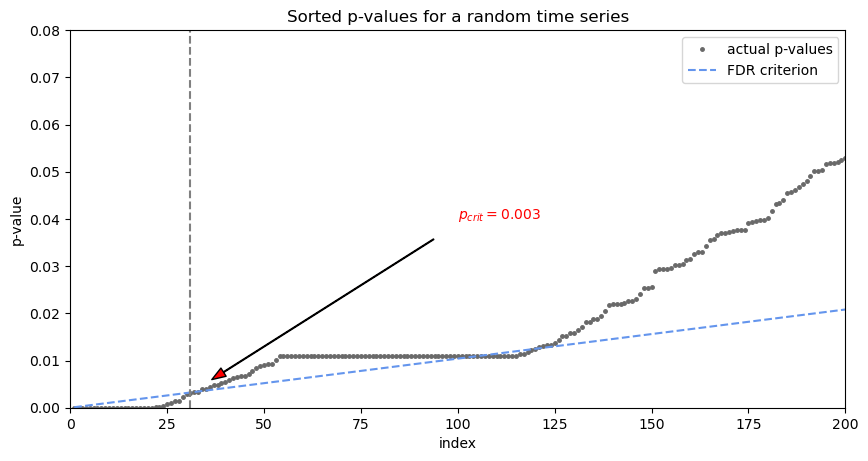

In [14]:
alpha = 0.2

Pvals = P.flatten()
Pvals = np.sort(Pvals)

x = np.arange(1,len(Pvals)+1,1)
x = x.astype(float)

plt.figure(figsize=(10,5))
plt.plot(x,Pvals,'.',color = 'dimgray', markersize = 5, label = 'actual p-values')

y = (x/len(x))*alpha
plt.plot(x,y,'--',color = 'cornflowerblue', label = 'FDR criterion')

if(randomSeries):
    xlimVal = 6200
    ylimVal = .4
else:
    xlimVal = 200
    ylimVal = .08
    
plt.xlim(0,xlimVal)
plt.ylim(0,ylimVal)
    
plt.xlabel('index')
plt.ylabel('p-value')

d = Pvals - y
k = np.where(d>0)[0][0] - 1 + 1
if(k==0):
    DNP = 1
    fdrPcutoff = 0.
else:
    DNP = 0
    fdrPcutoff = Pvals[k-1]
    plt.plot([k,k],[0,1],'--',color = 'gray')
    plt.annotate('$p_{crit} = $' + str(np.around(fdrPcutoff,3)), xy=(k,Pvals[k-1]),xytext=(xlimVal/2,ylimVal/2.),
             arrowprops=dict(facecolor='red', shrink=.08, width = 0.5, headlength = 10, headwidth=7),
             horizontalalignment = 'left',color = 'red')

plt.title('Sorted p-values for a random time series')
plt.legend()
plt.show() 

The intersection tells us what the p-value shoudl be to determine significant gridpoints. If there is no intersection of the actual p-values with the FDR criterion line then none of the stippled points in the map should be considered globally significant.

We can plot the results on a map again, where we use "x" to denote the p-values that fall below the global FDR p-value cutoff.

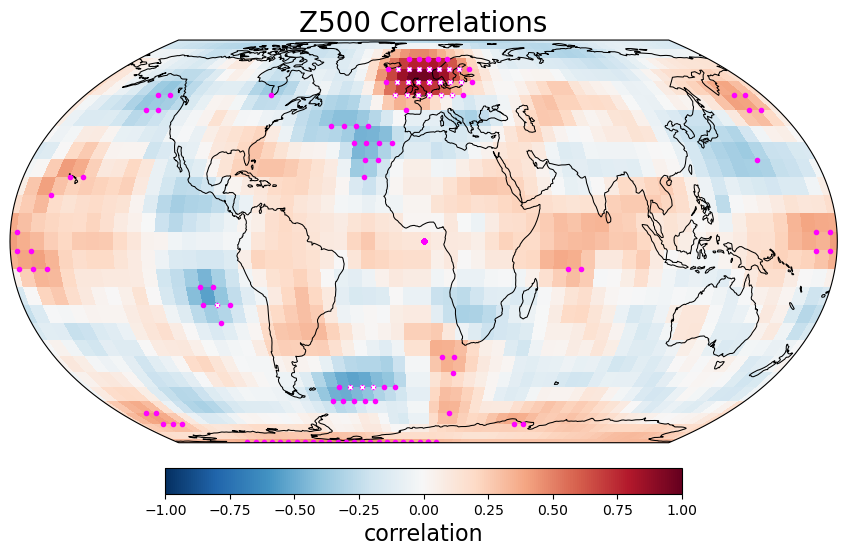

In [15]:
data_crs = ct.crs.PlateCarree()

plt.figure(figsize=(16/1.2,8/1.2))
ax = plt.subplot(projection=ct.crs.EqualEarth())
ax.set_global()
ax.coastlines(linewidth = .75)
image = ax.pcolor(LONG, LAT, C, transform=data_crs, cmap='RdBu_r', shading='auto')
cb = plt.colorbar(image, shrink=.5, orientation="horizontal", pad=.05)
cb.set_label('correlation', fontsize=16)
maxval = np.max(C[:])
image.set_clim(-maxval,maxval)

for ilat,vallat in enumerate(LAT):
    for ilon,vallon in enumerate(LONG):
        if(P[ilat,ilon]<0.05):
            ax.plot(vallon+np.abs(np.diff(LONG)[1])/2,vallat-np.abs(np.diff(LAT)[1])/2,'o',markersize = 3, color = 'fuchsia', transform=data_crs)
        if(P[ilat,ilon]<fdrPcutoff):
            ax.plot(vallon+np.abs(np.diff(LONG)[1])/2,vallat-np.abs(np.diff(LAT)[1])/2,'x',markersize = 3, color = 'white', transform=data_crs)

plt.title('Z500 Correlations', fontsize=20)
plt.show()
